<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models</h4>
    <p style="font-size: 20px;">Basketball Reference Data (2000-2024)</p>
</div>

<a name="Baseline Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Target: Game Winner](#1.-Target:-Game-Winner)**
  
**[2. Target: Total Points (over / under)](#2.-Target:-Total-Points-(over-/-under))**

- [2.1. Setup](#2.1.-Setup)

- [2.2. Time Series Cross-Validation](#2.2.-Time-Series-Cross-Validation)

- [2.3. Manual Rolling Window](#2.3.-Manual-Rolling-Window)

**[3. Target: Difference in Points (plus / minus)](#3.-Target:-Difference-in-Points-(plus-/-minus))**

# Setup

[Return to top](#Baseline-Models)

In [57]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

# Data

[Return to top](#Baseline-Models)

In [47]:
team_matchups_df = pd.read_csv('../data/processed/br_team_matchups_2000_2024.csv')

# convert 'date' column to datetime
team_matchups_df['date'] = pd.to_datetime(team_matchups_df['date'])

In [48]:
team_matchups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30752 entries, 0 to 30751
Data columns (total 41 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   season                                  30752 non-null  int64         
 1   date                                    30752 non-null  datetime64[ns]
 2   start_time                              30752 non-null  object        
 3   home_team                               30752 non-null  object        
 4   away_team                               30752 non-null  object        
 5   home_team_score                         30752 non-null  int64         
 6   away_team_score                         30752 non-null  int64         
 7   home_outcome                            25812 non-null  object        
 8   home_minutes_played                     25812 non-null  float64       
 9   home_made_field_goals                   25812 non-

In [49]:
team_matchups_df.head()

,season,date,start_time,home_team,away_team,home_team_score,away_team_score,home_outcome,home_minutes_played,home_made_field_goals,home_attempted_field_goals,home_made_three_point_field_goals,home_attempted_three_point_field_goals,home_made_free_throws,home_attempted_free_throws,home_offensive_rebounds,home_defensive_rebounds,home_assists,home_steals,home_blocks,home_turnovers,home_personal_fouls,home_points,away_assists,away_attempted_field_goals,away_attempted_free_throws,away_attempted_three_point_field_goals,away_blocks,away_defensive_rebounds,away_made_field_goals,away_made_free_throws,away_made_three_point_field_goals,away_minutes_played,away_offensive_rebounds,away_outcome,away_personal_fouls,away_points,away_steals,away_turnovers,score_total,score_diff
0,2000,1999-11-02,1999-11-02 05:00:00+00:00,Charlotte Hornets,Orlando Magic,100,86,Win,240.0,34.0,82.0,10.0,22.0,22.0,37.0,14.0,33.0,25.0,13.0,5.0,21.0,25.0,100.0,17.0,80.0,27.0,8.0,4.0,36.0,34.0,18.0,0.0,240.0,12.0,Loss,31.0,86.0,9.0,22.0,186,14
1,2000,1999-11-02,1999-11-02 05:00:00+00:00,Dallas Mavericks,Golden State Warriors,108,96,Win,240.0,39.0,85.0,2.0,15.0,28.0,34.0,11.0,30.0,22.0,11.0,6.0,13.0,19.0,108.0,14.0,82.0,27.0,18.0,2.0,33.0,34.0,21.0,7.0,240.0,18.0,Loss,29.0,96.0,4.0,23.0,204,12
2,2000,1999-11-02,1999-11-02 05:00:00+00:00,Denver Nuggets,Phoenix Suns,107,102,Win,265.0,40.0,89.0,8.0,18.0,19.0,26.0,13.0,42.0,25.0,6.0,16.0,18.0,17.0,107.0,29.0,111.0,14.0,22.0,5.0,37.0,43.0,7.0,9.0,265.0,21.0,Loss,28.0,102.0,9.0,13.0,209,5
3,2000,1999-11-02,1999-11-02 05:00:00+00:00,Houston Rockets,Milwaukee Bucks,93,98,Loss,240.0,34.0,75.0,6.0,20.0,19.0,29.0,15.0,27.0,22.0,5.0,7.0,18.0,24.0,93.0,20.0,79.0,28.0,7.0,2.0,25.0,38.0,19.0,3.0,240.0,10.0,Win,25.0,98.0,10.0,8.0,191,-5
4,2000,1999-11-02,1999-11-02 05:00:00+00:00,Los Angeles Clippers,Seattle Supersonics,92,104,Loss,240.0,35.0,78.0,6.0,16.0,16.0,27.0,12.0,33.0,14.0,4.0,9.0,17.0,24.0,92.0,25.0,93.0,32.0,20.0,3.0,34.0,37.0,23.0,7.0,240.0,19.0,Win,21.0,104.0,8.0,11.0,196,-12


In [50]:
team_matchups_df.describe()

,season,date,home_team_score,away_team_score,home_minutes_played,home_made_field_goals,home_attempted_field_goals,home_made_three_point_field_goals,home_attempted_three_point_field_goals,home_made_free_throws,home_attempted_free_throws,home_offensive_rebounds,home_defensive_rebounds,home_assists,home_steals,home_blocks,home_turnovers,home_personal_fouls,home_points,away_assists,away_attempted_field_goals,away_attempted_free_throws,away_attempted_three_point_field_goals,away_blocks,away_defensive_rebounds,away_made_field_goals,away_made_free_throws,away_made_three_point_field_goals,away_minutes_played,away_offensive_rebounds,away_personal_fouls,away_points,away_steals,away_turnovers,score_total,score_diff
count,30752.000,30752,30752.000,30752.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,25812.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,26114.000,30752.000,30752.000
mean,2011.483,2011-07-25 14:14:03.808532736,102.942,99.994,241.720,38.240,83.081,7.796,21.618,18.609,24.482,11.230,32.134,22.962,7.629,5.188,13.656,20.728,102.884,21.485,82.956,23.484,21.539,4.655,31.103,37.222,17.802,7.615,241.739,10.883,21.392,99.862,7.548,13.949,202.936,2.949
min,2000.000,1999-11-02 00:00:00,56.000,53.000,240.000,17.000,51.000,0.000,1.000,1.000,2.000,0.000,13.000,6.000,0.000,0.000,1.000,6.000,56.000,3.000,55.000,1.000,1.000,0.000,12.000,16.000,1.000,0.000,240.000,0.000,5.000,53.000,0.000,2.000,121.000,-58.000
25%,2006.000,2005-11-05 00:00:00,94.000,91.000,240.000,34.000,78.000,5.000,14.000,14.000,19.000,8.000,28.000,19.000,6.000,3.000,11.000,18.000,94.000,18.000,78.000,18.000,14.000,3.000,27.000,34.000,13.000,5.000,240.000,8.000,18.000,91.000,5.000,11.000,187.000,-6.000
50%,2011.000,2011-04-05 00:00:00,103.000,99.000,240.000,38.000,83.000,7.000,20.000,18.000,24.000,11.000,32.000,23.000,7.000,5.000,13.000,21.000,102.000,21.000,83.000,23.000,20.000,4.000,31.000,37.000,17.000,7.000,240.000,11.000,21.000,99.000,7.000,14.000,202.000,4.000
75%,2017.000,2017-04-09 00:00:00,112.000,109.000,240.000,42.000,88.000,10.000,28.000,23.000,29.000,14.000,36.000,26.000,9.000,7.000,16.000,24.000,112.000,25.000,88.000,28.000,28.000,6.000,35.000,41.000,22.000,10.000,240.000,13.000,24.000,109.000,9.000,16.000,218.000,12.000
max,2023.000,2023-06-12 00:00:00,175.000,176.000,340.000,62.000,125.000,28.000,70.000,48.000,64.000,33.000,55.000,47.000,22.000,23.000,30.000,43.000,175.000,46.000,126.000,64.000,61.000,19.000,60.000,65.000,52.000,29.000,340.000,29.000,42.000,176.000,20.000,32.000,351.000,73.000
std,6.902,NaN,13.403,13.520,7.338,5.464,7.923,4.188,9.480,6.302,7.789,4.024,5.481,5.208,2.944,2.680,3.852,4.407,13.384,5.151,7.978,7.504,9.434,2.462,5.438,5.396,6.098,4.127,7.427,3.959,4.591,13.472,2.896,3.939,23.365,13.376


<a name="1.-Target:-Game-Winner"></a>
# 1. Target: Game Winner

[Return to top](#Baseline-Models)

<a name="2.-Target:-Total-Points-(over-/-under)"></a>
# 2. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="2.1.-Setup"></a>
## 2.1. Setup

[Return to top](#Baseline-Models)

In [93]:
# filter data to 1 year
# team_matchups_2023 = team_matchups_df[team_matchups_df['date'] >= '2023-01-01']
team_matchups_2000 = team_matchups_df[team_matchups_df['season'] == 2000]

# non-feature columns
omit_cols = [
  'season', 'date', 'start_time', 'home_team', 'away_team', 'home_team_score', 
  'away_team_score', 'home_outcome', 'away_outcome', 'score_diff'
]

# drop non-features
team_matchups_2000_subset = team_matchups_2000.drop(omit_cols, axis=1)

# get all features excluding the target
features = team_matchups_2000_subset.drop('score_total', axis=1)  

# get target
target = team_matchups_2000_subset['score_total']  

# min-max scaling for features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# recombine scaled features with the target
scaled_data = np.concatenate([scaled_features, target.values.reshape(-1, 1)], axis=1)

# convert scaled data back to DataFrame and reset index
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.columns = team_matchups_2000_subset.columns
scaled_data_df = scaled_data_df.reset_index(drop=True)

In [73]:
team_matchups_2000.head()

,home_minutes_played,home_made_field_goals,home_attempted_field_goals,home_made_three_point_field_goals,home_attempted_three_point_field_goals,home_made_free_throws,home_attempted_free_throws,home_offensive_rebounds,home_defensive_rebounds,home_assists,home_steals,home_blocks,home_turnovers,home_personal_fouls,home_points,away_assists,away_attempted_field_goals,away_attempted_free_throws,away_attempted_three_point_field_goals,away_blocks,away_defensive_rebounds,away_made_field_goals,away_made_free_throws,away_made_three_point_field_goals,away_minutes_played,away_offensive_rebounds,away_personal_fouls,away_points,away_steals,away_turnovers,score_total
0,240.0,34.0,82.0,10.0,22.0,22.0,37.0,14.0,33.0,25.0,13.0,5.0,21.0,25.0,100.0,17.0,80.0,27.0,8.0,4.0,36.0,34.0,18.0,0.0,240.0,12.0,31.0,86.0,9.0,22.0,186
1,240.0,39.0,85.0,2.0,15.0,28.0,34.0,11.0,30.0,22.0,11.0,6.0,13.0,19.0,108.0,14.0,82.0,27.0,18.0,2.0,33.0,34.0,21.0,7.0,240.0,18.0,29.0,96.0,4.0,23.0,204
2,265.0,40.0,89.0,8.0,18.0,19.0,26.0,13.0,42.0,25.0,6.0,16.0,18.0,17.0,107.0,29.0,111.0,14.0,22.0,5.0,37.0,43.0,7.0,9.0,265.0,21.0,28.0,102.0,9.0,13.0,209
3,240.0,34.0,75.0,6.0,20.0,19.0,29.0,15.0,27.0,22.0,5.0,7.0,18.0,24.0,93.0,20.0,79.0,28.0,7.0,2.0,25.0,38.0,19.0,3.0,240.0,10.0,25.0,98.0,10.0,8.0,191
4,240.0,35.0,78.0,6.0,16.0,16.0,27.0,12.0,33.0,14.0,4.0,9.0,17.0,24.0,92.0,25.0,93.0,32.0,20.0,3.0,34.0,37.0,23.0,7.0,240.0,19.0,21.0,104.0,8.0,11.0,196


In [74]:
scaled_data_df.head()

,home_minutes_played,home_made_field_goals,home_attempted_field_goals,home_made_three_point_field_goals,home_attempted_three_point_field_goals,home_made_free_throws,home_attempted_free_throws,home_offensive_rebounds,home_defensive_rebounds,home_assists,home_steals,home_blocks,home_turnovers,home_personal_fouls,home_points,away_assists,away_attempted_field_goals,away_attempted_free_throws,away_attempted_three_point_field_goals,away_blocks,away_defensive_rebounds,away_made_field_goals,away_made_free_throws,away_made_three_point_field_goals,away_minutes_played,away_offensive_rebounds,away_personal_fouls,away_points,away_steals,away_turnovers,score_total
0,0.0,0.382,0.44,0.667,0.625,0.488,0.542,0.367,0.576,0.432,0.632,0.25,0.667,0.471,0.500,0.400,0.407,0.415,0.171,0.267,0.690,0.406,0.359,0.000,0.0,0.375,0.703,0.328,0.421,0.655,186.0
1,0.0,0.529,0.50,0.133,0.406,0.634,0.492,0.267,0.485,0.351,0.526,0.30,0.370,0.294,0.608,0.314,0.444,0.415,0.457,0.133,0.586,0.406,0.436,0.500,0.0,0.625,0.649,0.484,0.158,0.690,204.0
2,0.5,0.559,0.58,0.533,0.500,0.415,0.356,0.333,0.848,0.432,0.263,0.80,0.556,0.235,0.595,0.743,0.981,0.170,0.571,0.333,0.724,0.688,0.077,0.643,0.5,0.750,0.622,0.578,0.421,0.345,209.0
3,0.0,0.382,0.30,0.400,0.562,0.415,0.407,0.400,0.394,0.351,0.211,0.35,0.556,0.441,0.405,0.486,0.389,0.434,0.143,0.133,0.310,0.531,0.385,0.214,0.0,0.292,0.541,0.516,0.474,0.172,191.0
4,0.0,0.412,0.36,0.400,0.438,0.341,0.373,0.300,0.576,0.135,0.158,0.45,0.519,0.441,0.392,0.629,0.648,0.509,0.514,0.200,0.621,0.500,0.487,0.500,0.0,0.667,0.432,0.609,0.368,0.276,196.0


<a name="2.2.-Time-Series-Cross-Validation"></a>
## 2.2. Time Series Cross-Validation

[Return to top](#Baseline-Models)

In [94]:
# feature columns
X = scaled_data_df.drop('score_total', axis=1)

# target column
y = scaled_data_df['score_total']

In [95]:
# initialize TimeSeriesSplit
# n_splits = 12 # roughly monthly
n_splits = len(X) - 1 # LOO
tscv = TimeSeriesSplit(n_splits=n_splits)

# initialize model
glm = LinearRegression()

# storage for predictions and MSE
predictions = []
mse_scores = []

start_time = time.time()

# iterate over each time split
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit model on training data and predict on test data
    glm.fit(X_train, y_train)
    prediction = glm.predict(X_test)
    predictions.append(prediction[0])
    
    # evaluate model
    mse = mean_squared_error(y_test, prediction)
    mse_scores.append(mse)

# get average MSE over all splits
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average Mean Squared Error: {average_mse}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

Average Mean Squared Error: 4.8463071091258625
Total time taken: 3.0500659942626953 seconds


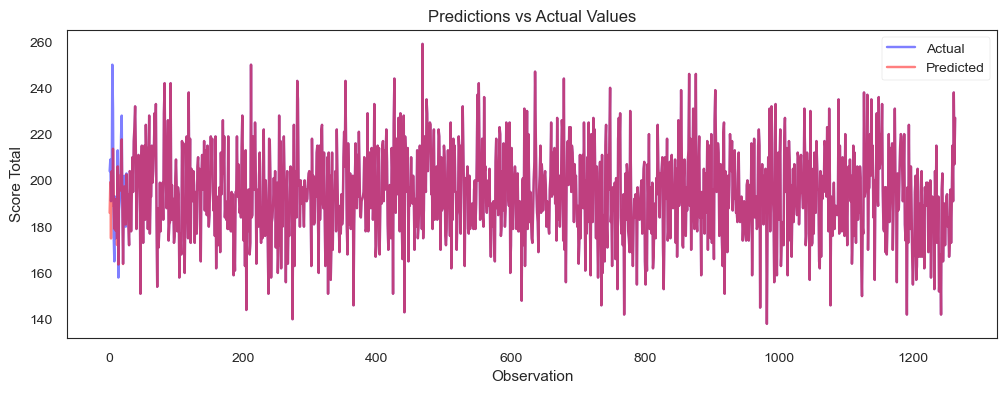

In [96]:
# get observations
observed_values = y.iloc[1:]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Actual', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Actual Values')
plt.xlabel('Observation')
plt.ylabel('Score Total')
plt.legend();

<a name="2.3.-Manual-Rolling-Window"></a>
## 2.3. Manual Rolling Window

[Return to top](#Baseline-Models)

In [97]:
start_time = time.time()

# define window size
window_size = 30 

# storage for predictions
predictions = []

# rolling window loop
for start_index in range(len(scaled_data) - window_size):
    end_index = start_index + window_size

    # training data for this window
    X_train = scaled_data[start_index:end_index, :-1]  # all features, excluding target
    y_train = scaled_data[start_index:end_index, -1]   # target feature

    # next observation to predict
    X_next = scaled_data[end_index, :-1].reshape(1, -1)  # reshape for single prediction

    # train the linear model
    glm = LinearRegression()
    glm.fit(X_train, y_train)

    # Predict the next value and store the prediction
    prediction = glm.predict(X_next)
    predictions.append(prediction[0])

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

Total time taken: 0.30946779251098633 seconds


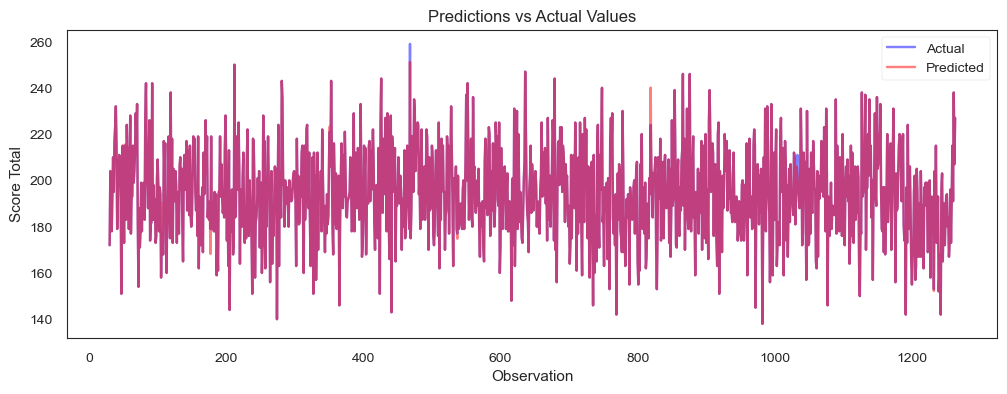

In [98]:
# aligning the start of predictions with the actual values
# The first prediction corresponds to the observation at index window_size
observed_values = scaled_data_df['score_total'][window_size:]

# ensure that 'predictions' and 'actual_values' have the same length
# this is necessary because the last few values of df['score_total'] won't have corresponding predictions
predictions_aligned = predictions[:len(actual_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Actual', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Actual Values')
plt.xlabel('Observation')
plt.ylabel('Score Total')
plt.legend();

<a name="3.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 3. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)